# Ford Go-Bike Data

## by Mehmet Cenk Bursali

## Investigation Overview

In this investigation, I wanted to look at the different features of Ford Go-Bike system that could affect rent duration. The main focus was hours, weekdays, gender and age.

## Dataset Overview

The dataset contains 183412 rental transactions and their 16 features. Rent duration, start-end times, locaiton and name of start-end stations, gender and age of members are given. Over a thousand lines were removed from the analysis due to inconsistencies or missing information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv("ford_go_bike_trip_data.csv")

In [3]:
df1 = df.copy()
df1 = df1.drop(['start_station_id', 'end_station_id', 'bike_id'], axis=1)
df1 = df1[df1['start_station_name'].notnull()]
df1 = df1[df1['member_birth_year'].notnull()]
df1['member_age'] = 2019-df1['member_birth_year']
df1['hour'] = df1['start_time'].str[11:13].astype('category')
bin_edges = [17.5,30.5,45.5,65.5,90.5]
df1['age_group'] = pd.cut(df1['member_age'], bin_edges, labels=['low', 'low_med', "high-mid", 'high'])
order=['low', 'low_med', "high-mid", 'high']
age_group = pd.api.types.CategoricalDtype(categories=order, ordered=True)
df1['age_group'] = df1['age_group'].astype(age_group)
def day_in_week(x):
    if x%7 == 4:
        return 'monday'
    elif x%7 == 5:
        return 'tuesday'
    elif x%7 == 6:
        return 'wednesday'
    elif x%7 == 0:
        return 'thursday'
    elif x%7 == 1:
        return 'friday'
    elif x%7 == 2:
        return 'saturday'
    elif x%7 == 3: 
        return 'sunday'
df1['day_in_week'] = df1['start_time'].astype('str').str[8:10].astype('int').apply(day_in_week)
order = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
day_in_week = pd.api.types.CategoricalDtype(categories=order, ordered=True)
df1['day_in_week'] = df1['day_in_week'].astype(day_in_week)
def weekday_or_not(x):
    if x%7 in [2,3]:
        return 'weekend'
    else: 
        return 'weekday'
df1['workday_or_not'] = df1['start_time'].astype('str').str[8:10].astype('int').apply(weekday_or_not)
x_dist = (df1['start_station_longitude']-df1['end_station_longitude'])*88.1
y_dist = (df1['start_station_latitude']-df1['end_station_latitude'])*111
df1['distance'] = np.sqrt(np.power(x_dist,2)+np.power(y_dist,2))*1000
df1['day_in_month'] = df1['start_time'].str[8:10]                                      
df1['day_period'] = df1['hour'].astype('str').replace(['21','22','23','00','01','02','03','04','05'],'night')
df1['day_period'] = df1['day_period'].astype('str').replace(['06','07','08','09','10'],'morning')
df1['day_period'] = df1['day_period'].astype('str').replace(['11','12','13','14','15'],'afternoon')
df1['day_period'] = df1['day_period'].astype('str').replace(['16','17','18','19','20'],'evening')
order=['morning','afternoon','evening','night']
day_per = pd.api.types.CategoricalDtype(categories=order, ordered=True)
df1['day_period'] = df1['day_period'].astype(day_per)    
df1 = df1.query('duration_sec<5000')
df1 = df1.query('member_age<=90')
df1 = df1.query('member_gender in ["Female", "Male"]')
bin_edges = [-122.5, -122.35, -122, -121.8]
df1['regions'] = pd.cut(df1['start_station_longitude'], bin_edges, labels=['west', 'middle', "east"])

## Distribution of Bike Rent Periods

Bike rent durations in the dataset take on a very large range of values, from about  61 seconds at the shortest to about a few hours at the longest. Plotted on a logarithmic scale, the distribution of durations takes on a uniimodal shape.

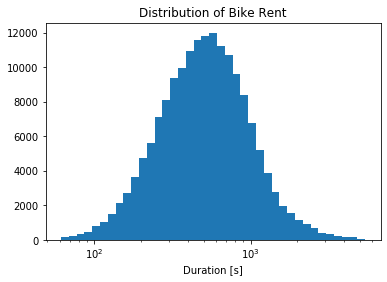

In [4]:
bins = 10**np.arange(np.log10(df1['duration_sec']).min(), np.log10(5000).max()+.05, .05)

plt.hist(data=df1.query('duration_sec<5000'), x='duration_sec', bins=bins)
plt.xscale('log')
plt.xlabel('Duration [s]')
plt.title('Distribution of Bike Rent');

## Counts in Days of Week

Data is from February, 2019. Because of february in 2019 is 28 days, each week day falls into this month 4 times. 

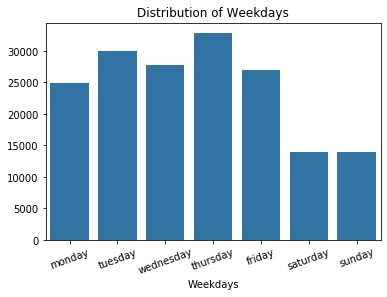

In [5]:
base_color = sb.color_palette()[0]
sb.countplot(df1['day_in_week'], color=base_color)
plt.xticks(rotation=20)
plt.ylabel("")
plt.xlabel("Weekdays");
plt.title('Distribution of Weekdays');

## Duration vs. Distance

Longitudes and latitudees of start and end stations are given in the dataset. Using this, air distance between start and end stations can be calculated. Plotting duration and distance in a linear scale produces an approximately linear relationship. This can mean that people use bikes for transportation more than touring.  

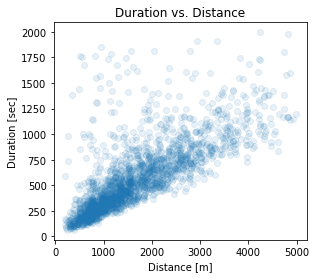

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(data=df1.query('5000>distance>0 and duration_sec<2000').sample(2000), x='distance', y='duration_sec', alpha=.1)
plt.title('Duration vs. Distance')
plt.xlabel('Distance [m]')
plt.ylabel('Duration [sec]');

## Bike Share for All Trip program in east region 

Ford GoBike presents a program called "Bike Share for All" program for low-income residents in the city. In the bar plot below, it seems that more than 90% of users are not registered.

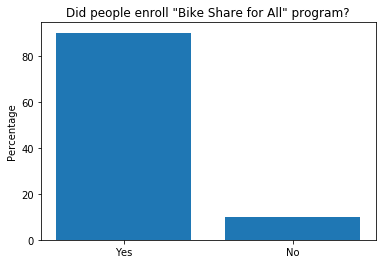

In [7]:
plt.bar(df1['bike_share_for_all_trip'].unique(), df1['bike_share_for_all_trip'].value_counts(sort=False)/len(df1)*100)
plt.title('Did people enroll "Bike Share for All" program?')
plt.ylabel('Percentage');

However, the distribution of participants in the program in the eastern region is very different from the general situation. This means that low-income residents live in the eastern region.

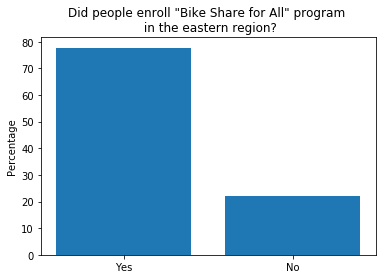

In [8]:
plt.bar(sorted(df1.query('regions=="east"')['bike_share_for_all_trip'].unique(), reverse=True), 
        df1.query('regions=="east"')['bike_share_for_all_trip'].value_counts()/len(df1.query('regions=="east"'))*100);
plt.title('Did people enroll "Bike Share for All" program \n in the eastern region?')
plt.ylabel('Percentage');

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!